---
authors:
  - name: Tom Siegl
---

# 09: Experiment Design

We know how to simulate the spread of an infection by encoding the SIR model as a CTMC.

In this exercise we will deal with the problem of extracting some knowledge out of this model, while caring about the computational resources we use for that.

This will require us to run CTMCs of the SIR model with different parameters.

## A CTMC for the SIR Model

As a foundation to do experiments, here is an implementation of the simple CTMC simulation algorithm from the lecture and a SIR model definition to go with it. (Run the first three code cells to see a simulation trajectory.)

This implementation may serve you as a reference for the CTMC semantics, in case it was not entirely clear from the lecture.
The function `run_ctmc()` is written in such a way that it is very similar to the pseudocode from the lecture.

In [1]:
import itertools
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

np.random.seed(0)

In [2]:
######################
### CTMC SIMULATOR ###
######################


class Reaction:
    def __init__(self, in_species, out_species, rate, mass_action_kinetics=False):
        self.in_species = in_species
        self.out_species = out_species
        self.rate = rate
        self.mass_action_kinetics = mass_action_kinetics

    def is_available(self, x):
        return np.all(self.in_species <= x)

    def get_delay(self, x):
        effective_rate = self.rate
        
        if self.mass_action_kinetics:
            effective_rate *= np.prod([math.comb(x[i], self.in_species[i]) for i in range(len(x))])

        return np.random.exponential(1/effective_rate)

    def get_change_vector(self):
        return self.out_species - self.in_species


def run_ctmc(x0, reactions, duration):
    x = x0.copy()
    time = 0
    
    xs = [[x.copy(), time]]
    
    while time < duration:
        posReactions = [r for r in reactions if r.is_available(x)]  # checkForReactions
        elapsed = np.inf
        nextReaction = None

        for reaction in posReactions:
            sigma = reaction.get_delay(x)

            if sigma < elapsed:
                nextReaction = reaction
                elapsed = sigma

        if nextReaction is None:
            break
        
        time += elapsed
        v = nextReaction.get_change_vector()
        x += v
        
        xs.append([x.copy(), time])

    xs[-1][1] = duration
    return xs

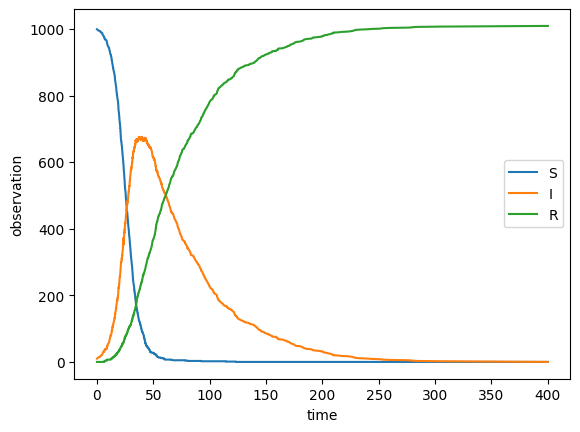

In [3]:
initial_state = np.array([999, 10, 0])

beta = 2e-4
mu = 2e-2

r1 = Reaction(np.array([1, 1, 0]), np.array([0, 2, 0]), beta, True)  # infecting
r2 = Reaction(np.array([0, 1, 0]), np.array([0, 0, 1]), mu, True)  # recovering
reactions = [r1, r2]

duration = 400

steps = run_ctmc(initial_state, reactions, duration)

# plot
plt.plot([step[1] for step in steps], [step[0][0] for step in steps], label='S')
plt.plot([step[1] for step in steps], [step[0][1] for step in steps], label='I')
plt.plot([step[1] for step in steps], [step[0][2] for step in steps], label='R')
plt.xlabel('time')
plt.ylabel('observation')
plt.legend()
plt.show()

## Full Factorial Design

Our main goal for today will be to try to study the effect of the parameters `beta` and `mu` on the way the simulation plays out.
We will capture "the way the simulation plays out" by computing a single scalar value from a trajectory, such as the maximum number of infected people at any time point or the number of infected people at the final time point in a trajectory.

This means we have two variables.
Let's just say we will test 10 different values ("levels") per variable.

:::{important} Tasks
1. How often do we need to run the CTMC simulator in a full factorial design?
2. Implement the full factorial design in the function `get_full_factorial` below. (**Hint**: The variable `level_idx` contains a list of levels for each variable, which you just need to combine in the right way to get all the parameter combinations in the full factorial design.)
:::

:::{tip} Your answer
:class:dropdown
1. 
:::

In [ ]:
#################################
### EXPERIMENT DESIGN SUMMARY ###
#################################


def plot_design_matrix(design_matrix, fig, ax, title='', c=None):
    ax.scatter(design_matrix[:, 0], design_matrix[:, 1], zorder=10, c=c)
    ax.set_xlabel('variable 1 level idx')
    ax.set_ylabel('variable 2 level idx')
    ax.set_xticks(np.unique(design_matrix[:, 0]))
    ax.set_yticks(np.unique(design_matrix[:, 1]))
    ax.set_title(title)
    ax.grid(True)


def is_latin_hypercube(design_matrix):
    for col in range(design_matrix.shape[1]):
        if len(np.unique(design_matrix[:, col])) != design_matrix.shape[0]:
            print("Nope. This is not a latin hypercube.")
            return
            
    print("Yes. This is a latin hypercube.")


def summarize_design(design_matrix):
    is_latin_hypercube(design_matrix)
    
    print()
    print("Number of Design Points:", np.prod(design_matrix.shape))
    print("Design Matrix Shape:", design_matrix.shape)
    print("Start of Design Matrix (transposed):\n", design_matrix[:20].T)
    print()
    
    # plot
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(111)
    plot_design_matrix(design_matrix, fig, ax)
    plt.show()

In [ ]:
def get_full_factorial(num_levels_per_var):
    level_idx = [list(range(num_levels)) for num_levels in num_levels_per_var]
    
    return None  # TODO: implement

In [ ]:
num_levels_per_var = 10
num_vars = 2

full_factorial = get_full_factorial([num_levels_per_var]*num_vars)

summarize_design(full_factorial)

You should now see a plot with a grid of 10x10 values and a point at each intersection of the grid lines.

Take note of the variables `num_levels_per_var` and `num_vars`, as we will keep using them to generate other experiment designs.

For now, let's take the design points we have and focus on performing our first experiment.
There is already the function `run_experiment` implemented for that and a code cell that uses it.
But in between, the definitions for the statistics we are interested in are missing.

:::{important} Tasks
1. Implement `infected_max`. It should take a simulation trajectory (a list of states from a simulation run) and return the maximum number of infected people at any time point.
2. Implement `infected_final`. It should take a simulation trajectory and return the number of infected people at the final time point.
3. What is the least and the greatest rate used in the experiment here?
4. The experiment doesn't make use of replications so far. Increase the number of replications to something more reasonable!
:::

:::{tip} Your answer
:class:dropdown
**3.** 
:::

In [ ]:
def run_experiment(init_state, reactions, duration, rates, statistic, num_replications, name=''):
    if len(reactions) != 2 or len(rates[0]) != 2:
        raise NotImplementedError()
    
    experiment_stats = []

    for beta, mu in tqdm(rates, desc=f'{name} experiment runs'):
        replication_stats = []
        for _ in range(num_replications):
            reactions[0].rate = beta
            reactions[1].rate = mu
            
            run_steps = run_ctmc(initial_state, reactions, duration)

            replication_stats.append(statistic(run_steps))

        experiment_stats.append(np.mean(replication_stats))

    return np.array(experiment_stats)


def plot_experiment_result(run_params, stats, initial_state, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
    
    scatter = ax.scatter(run_params[:, 0], run_params[:, 1], c=stats)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('beta')
    ax.set_ylabel('mu')
    ax.set_title(title)
    
    fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(0, np.sum(initial_state)), cmap='viridis'), ax=ax, label='statistic')
    plt.show()

In [ ]:
def infected_max(run_steps):
    pass  # TODO: implement


def infected_final(run_steps):
    pass  # TODO: implement

In [ ]:
rate_levels = np.logspace(-1, -5, num_levels_per_var)

full_fac_rates = rate_levels[full_factorial]
full_fac_exp_stats = run_experiment(initial_state, reactions, duration, full_fac_rates, infected_final, 1, name='full factorial')

plot_experiment_result(full_fac_rates, full_fac_exp_stats, initial_state, title='full factorial')

## Naive Latin Hypercube Sampling

Run the code cells in this section to see how a naive latin hypercube sampling would look like for our experiment setup.

:::{important} Tasks
1. What makes this a latin hypercube and why wasn't the full factorial design a latin hypercube? (**Hint**: Maybe it helps to know the origin of the name: Check out the [latin square article on Wikipedia](https://en.wikipedia.org/wiki/Latin_square).)
2. Why does it have to be a latin hyper**cube**? Can you come up with a latin hyper**rectangle** design for two variables?
3. What is the main advantage of latin hypercubes over full factorial designs for experimentation?
4. Latin hypercubes give a less complete view of the dynamics between parameters and their influence on the result compared to full factorial designs. What is the rationale to still use them?
5. What is the main problem with the naive latin hypercube sampling shown below?
:::

:::{tip} Your answer
:class:dropdown
1. 
2. 
3. 
4. 
5. 
:::

In [ ]:
def naive_lhs(num_levels_per_var, num_vars):
    level_idx = np.array([list(range(num_levels)) for num_levels in [num_levels_per_var]*num_vars])
    lh = []
    
    for level_i in range(level_idx.shape[1]):
        lh.append([level_idx[var_i, level_i] for var_i in range(level_idx.shape[0])])

    return np.array(lh)

In [ ]:
naive_lh = naive_lhs(num_levels_per_var, num_vars)

summarize_design(naive_lh)

In [ ]:
naive_lh_rates = rate_levels[naive_lh]
naive_lh_exp_stats = run_experiment(initial_state, reactions, duration, naive_lh_rates, infected_final, 5, name='naive lh')

plot_experiment_result(naive_lh_rates, naive_lh_exp_stats, initial_state, title='naive lh')

## Random Latin Hypercube Sampling

Run the code cells in this section to see how a random latin hypercube sampling would look like for our experiment setup.

:::{important} Tasks
1. What is the main advantage of this random sampling approach compared to the naive sampling from above?
2. Name two advantages of this random sampling approach compared to optimized latin hypercube sampling!
:::

:::{tip} Your answer
:class:dropdown
1. 
2. 
:::

In [ ]:
def random_lhs(num_levels_per_var, num_vars):
    level_idx = np.array([list(range(num_levels)) for num_levels in [num_levels_per_var]*num_vars])
    lh = []
    
    for var_i in range(level_idx.shape[0]):
        lh.append(np.random.permutation(level_idx[var_i]))

    return np.array(lh).T

In [ ]:
random_lh = random_lhs(num_levels_per_var, num_vars)

summarize_design(random_lh)

In [ ]:
random_lh_rates = rate_levels[random_lh]
random_lh_exp_stats = run_experiment(initial_state, reactions, duration, random_lh_rates, infected_final, 5, name='random lh')

plot_experiment_result(random_lh_rates, random_lh_exp_stats, initial_state, title='random lh')

## TPLHD: Optimized Latin Hypercube Sampling

As a reference with all the details, you can find the original paper that proposed the TPLHD algorithm for optimized latin hypercube sampling >>[here](https://doi.org/10.1002/nme.2750)<<.
You can also use the implementation below as another reference for this algorithm.

Feel free to play around with the implementation below, e.g.:
- Swap out the seed.
- Define a seed of your own.
- Change the number of levels per variable.

Go back to seed `tplhd_seed_0` and use `num_levels_per_var` from before for the number of levels per variable before you start with the tasks.

:::{important} Tasks
1. Describe how `tplhd_seed_3` is resized before the translation starts! (Write down a solution before generating the actual result using the code below.)
2. Draw the TPLHD result for `tplhd_seed_0` and `4` levels per variable! (Again, first come up with a solution, then use the code to check.)
3. Would it make sense to draw the points in the squares instead of on the lines?
4. In your drawing from task 2, mark the point that would be deleted to shrink the design to one with `3` levels per variable.
:::

:::{tip} Your answer
:class:dropdown
1. 
2. 
3. 
4. 
:::

In [ ]:
######################
### TPLHD SAMPLING ###
######################


def reshapeSeed(s, n_s, n_p_star, n_d_star, n_v):
    return s * n_d_star


def createTPLHD(s, n_s, n_p_star, n_d_star, n_v):
    translate = len(s) * n_d_star
    X = s
    
    for var_i in range(n_v):
        intermediate_seed = X.copy()
        X = [X]
        
        for div_i in range(n_d_star-1):
            intermediate_seed += 1
            intermediate_seed[:, var_i] += translate - 1
            X.append(intermediate_seed.copy())

        X = np.concatenate(X)

    return X


def resizeTPLHD(X, n_d_star, n_p, n_v):
    center = np.sum(X, axis=0) / X.shape[0]
    dists = np.sqrt((np.sum(np.square(X - center), axis=1)))

    dists_sorted_idx = np.argsort(dists)  # increasing order

    X = X.copy()[dists_sorted_idx]
    
    deleted_X = X[n_p:]
    X = X[:n_p]
    X_intermediate = X.copy()

    for var_i in range(n_v):
        deleted_sorted = np.sort(deleted_X[:, var_i])[::-1]  # decreasing order
        
        for deleted_val in deleted_sorted:
            X[X[:, var_i] > deleted_val, var_i] -= 1
    
    return X_intermediate, X


def TPLHD(n_p, n_v, s, n_s):
    """
    Implementation of https://onlinelibrary.wiley.com/doi/pdf/10.1002/nme.2750.
    
    :param n_p: Number of points to create
    :param n_v: Number of variables to create
    :param s: Seed definition array in shape (points, variables)
    :param n_s: Number of points in the seed
    :returns: Optimized latin hypercube design
    """
    n_d = (n_p/n_s)**(1/n_v)  # number divisions per variable (each division is one seed)
    n_d_star = int(np.ceil(n_d))  # number of integer divisions per variable to at least fill the levels

    n_b = None  # number of blocks
    if n_d_star > n_d:
        n_b = n_d_star**n_v  # each seed is a little more than one block (need to resize later)
    else:
        n_b = n_p / n_s  # each seed is one block (perfect fit)

    n_p_star = n_b * n_s  # number of points after seed-based construction and before resizing

    s = reshapeSeed(s, n_s, n_p_star, n_d_star, n_v)

    X = createTPLHD(s, n_s, n_p_star, n_d_star, n_v)

    X_intermediate = X
    X_resize = X
    if n_p_star > n_p:
        X_intermediate, X_resize = resizeTPLHD(X, n_d_star, n_p, n_v)

    return X, X_intermediate, X_resize

In [ ]:
tplhd_seed_0 = np.array([[0, 0]])
tplhd_seed_1 = np.array([[1, 1], [0, 0]])
tplhd_seed_2 = np.array([[0, 0], [1, 2], [2, 1]])
tplhd_seed_3 = np.array([[0, 0], [1, 2], [2, 1], [3, 3]])

tplhd_seed = tplhd_seed_0
pre_resize_lh, intermediate_lh, optimized_lh = TPLHD(num_levels_per_var, num_vars, tplhd_seed, tplhd_seed.shape[0])


is_latin_hypercube(optimized_lh)


# plot
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(131)
plot_design_matrix(tplhd_seed, fig, ax1, title='seed')

ax2 = fig.add_subplot(132)
plot_design_matrix(pre_resize_lh, fig, ax2, title='TPLHD before resizing', c='red')
ax2.scatter(intermediate_lh[:, 0], intermediate_lh[:, 1], zorder=20)

ax2 = fig.add_subplot(133)
plot_design_matrix(optimized_lh, fig, ax2, title='TPLHD')

plt.show()

For the phi criterion we just use the existing implementation from pyLHD:
- [GitHub](https://github.com/toledo60/pyLHD)
- [Documentation](https://pylhd.netlify.app/notebooks/intro_pylhd)

This package also comes with a collection of many more optimized latin hypercube sampling algorithms.

:::{important} Tasks
1. What is the meaning of the output of the following code cell w.r.t. comparing the sampling methods?
:::

:::{tip} Your answer
:class:dropdown
1. 
:::

In [ ]:
import pyLHD

print(f'Naive:          {pyLHD.phi_p(naive_lh, p=15, q=2):.3f}')
print(f'Random:         {pyLHD.phi_p(random_lh, p=15, q=2):.3f}')
print(f'TPLHD:          {pyLHD.phi_p(optimized_lh, p=15, q=2):.3f}')

## Summary/Overview

Let's look back on the experiment designs we have worked with today.

The code below gives us a plot of the experiment result for each design, showing the `infected_final` statistic.

:::{important} Tasks
1. Given these results, which of the designs do you think you would personally use in practice?
2. Edit the code below so it shows results for the statistic `infected_max` instead of `infected_final`. How does this affect your choice?
:::

:::{tip} Your answer
:class:dropdown
1. 
2. 
:::

In [ ]:
experiment_designs = []
experiment_designs.append(('full factorial', full_factorial))
experiment_designs.append(('naive lhs', naive_lh))
experiment_designs.append(('random lhs', random_lh))
experiment_designs.append(('TPLHD', optimized_lh))


# plot
fig, axes = plt.subplots(nrows=1, ncols=len(experiment_designs), figsize=(len(experiment_designs)*6 + 2, 5))

for i in range(len(experiment_designs)):
    run_params = rate_levels[experiment_designs[i][1]]
    stats = run_experiment(initial_state, reactions, duration, run_params, infected_final, 5, experiment_designs[i][0])
    # stats = run_experiment(initial_state, reactions, duration, run_params, infected_max, 5, experiment_designs[i][0])

    scatter = axes[i].scatter(run_params[:, 0], run_params[:, 1], c=stats)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel('beta')
    axes[i].set_ylabel('mu')
    axes[i].set_title(experiment_designs[i][0])

fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(0, np.sum(initial_state)), cmap='viridis'), ax=axes.ravel().tolist(), label='statistic')
plt.show()